### NB-1: Measure linkage decay as topology changes
Goal: take a sequence of newick trees (organized in a **strange** directory) and, for each tree, determine if a specific bipartition is present.

In [1]:
# pip install strange
# conda install seq-gen -c bioconda
# conda install toytree -c eaton-lab
# #strange includes local raxml-ng 

In [2]:
import numpy as np
import pandas as pd
import strange
import toytree
import toyplot

In [3]:
assert int(toytree.__version__.split(".")[-1]) >= 19, "update toytree"
print("toytree", toytree.__version__)
print("strange", strange.__version__)

toytree 0.1.21
strange 0.2.1-dev


### Define species trees

In [4]:
imb = toytree.tree("(((((((1,2),3),4),5),6),7),8);").mod.make_ultrametric()
imb5 = imb.mod.node_scale_root_height(5)
imb10 = imb.mod.node_scale_root_height(10)

bal = toytree.tree("(((1,2),(3,4)),((5,6),(7,8)));").mod.make_ultrametric()
bal5 = bal.mod.node_scale_root_height(5)
bal10 = bal.mod.node_scale_root_height(10)

### Plot species trees

In [5]:
trees = toytree.mtree([imb5, imb10, bal5, bal10])
canvas, axes = trees.draw_tree_grid(shared_axis=True, orient='down', height=250, width=700)
axes.y.domain.min = -1

2 1 3 4 5 6 7 8 2 1 3 4 5 6 7 8 8 7 6 5 4 3 2 1 8 7 6 5 4 3 2 1 0.0 2.5 5.0 7.5 10.0

### Generate gene trees on species trees

Simulate a chromosome 1Mbp in length with a mutation rate 10X > than recombination rate. This is the result of the function `Coalseq.simulate()` called by `__init__`. 

In [6]:
kwargs = {
    "workdir": "../tests",
    "mutation_rate": 1e-8, 
    "recombination_rate": 1e-9,
    "theta": 0.01, 
    "length": int(1e5), 
    "random_seed": 12345,
}

In [8]:
# setup simulation objects
simi5 = strange.Coalseq(tree=imb5, name="imb5", **kwargs)
simi10 = strange.Coalseq(tree=imb10, name="imb10", **kwargs)
simb5 = strange.Coalseq(tree=bal5, name="bal5", **kwargs)
simb10 = strange.Coalseq(tree=bal10, name="bal10", **kwargs)

# run simulations
sims = [simi5, simi10, simb5, simb10]
for sim in sims:
    sim.run()

### The tree table
This is the result of `Coalseq.get_tree_table()` and `Coalseq.get_sequences()`. For each interval the true genealogy is stored as well as `nsnps` in the simulated sequence data. 

In [9]:
simi5.tree_table.head(10)

,start,end,length,nsnps,mstree
0,0,72,72,15,"(((3:1184558.40707508823834,4:1184558.40707508..."
1,72,360,288,35,"(((3:1184558.40707508823834,4:1184558.40707508..."
2,360,517,157,24,"(((3:1184558.40707508823834,4:1184558.40707508..."
3,517,527,10,2,"(((3:1184558.40707508823834,4:1184558.40707508..."
4,527,541,14,2,"(((3:1184558.40707508823834,4:1184558.40707508..."
5,541,587,46,5,"(((3:1184558.40707508823834,4:1184558.40707508..."
6,587,608,21,4,"(((5:1462662.75042662885971,(1:363572.41155829..."
7,608,814,206,30,"(((5:1462662.75042662885971,(1:879708.30807612..."
8,814,957,143,26,"(((5:1462662.75042662885971,(1:879708.30807612..."
9,957,1413,456,75,"((8:2557484.07807051297277,6:2557484.078070512..."


### The clade table
This is the result of `Coalseq.get_clade_table()`. It records for each split in the species tree (referenced by the node idx under the split) whether that split is present in each genealogy interval. 


In [10]:
simi5.clade_table.head(10)

,8,9,10,11,12,13
0,1,0,0,1,0,0
1,1,0,0,1,0,0
2,1,0,0,1,0,0
3,1,0,0,1,0,0
4,1,0,0,1,0,0
5,1,0,0,1,0,0
6,1,0,0,1,0,0
7,1,0,0,1,0,0
8,1,0,0,1,0,0
9,1,0,0,1,0,0


### Information content of fragments

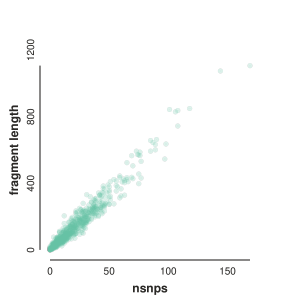

In [11]:
toyplot.config.autoformat = "png"
toyplot.scatterplot(
    simi5.tree_table.nsnps, 
    simi5.tree_table.length,
    width=300, height=300,
    opacity=0.25,
    xlabel='nsnps', ylabel='fragment length',
);

In [12]:
toyplot.config.autoformat = "html"
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.cartesian(xlabel="fragment length")
axes.bars(
    np.histogram(simi5.tree_table.length),
);

0 400 800 1200 fragment length 0 100 200 300 400

### Measure clade support along chromosome

In [13]:
def map_node_colors(ttree):
    ncolors = ttree.get_node_values('idx')
    cidx = 0
    for i in range(len(ncolors)):
        if i in ncolors:
            nidx = ncolors.index(i)
            ncolors[nidx] = toytree.colors[cidx]
            cidx += 1
    return ncolors

In [21]:
# c = toyplot.Canvas()
# a = c.cartesian()
# a.fill()

In [30]:
def tree_clades_slider_plot(self):
    canvas = toyplot.Canvas(width=500, height=550)
    ax0 = canvas.cartesian(bounds=(75, 425, 50, 250))
    ax1 = canvas.cartesian(bounds=(50, 450, 300, 500), xlabel="Genomic position (Mb)")

    self.tree.draw(
        axes=ax0,
        orient='down', 
        node_sizes=17,
        node_labels=self.tree.get_node_values("idx"),
        node_style={"stroke": "#262626", "fill-opacity": 0.9},
        node_colors=map_node_colors(self.tree),
        tip_labels=False,
    )

    breakpoints = self.tree_table.start
    base = np.zeros(breakpoints.size, dtype=int)
    for col in self.clade_table:
        ax1.fill(
            a=breakpoints,
            b=base,
            c=base + self.clade_table[col].astype(int), 
            opacity=0.9,
        )
        base += 1

    # styling
    ax0.show = False
    ax1.y.ticks.locator = toyplot.locator.Explicit(
        locations=np.arange(0, 6) + 0.5,
        labels=range(8, 14),
    )
    ax1.x.ticks.locator = toyplot.locator.Explicit(
        locations=np.linspace(0, 100000, 10),
        labels=range(0, 10),
    )
    ax1.x.ticks.show = True
    ax1.y.ticks.labels.angle = -90
    return canvas, (ax0, ax1)

In [31]:
# for saving figures
import toyplot.svg
import toyplot.pdf

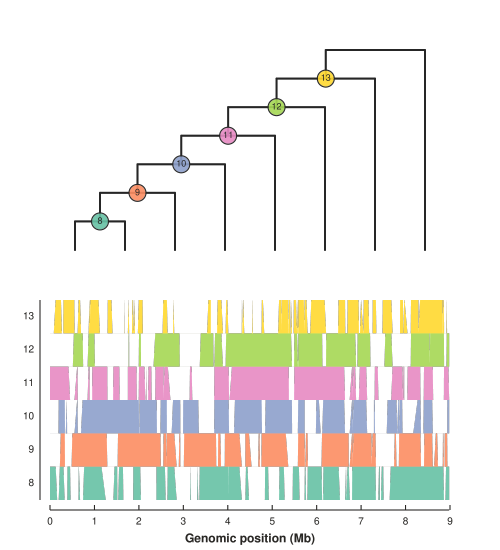

In [32]:
canvas, axes = tree_clades_slider_plot(simi5)
toyplot.html.render(canvas, "../figures/imbalanced_5.html")
toyplot.pdf.render(canvas, "../figures/imbalanced_5.pdf")
canvas

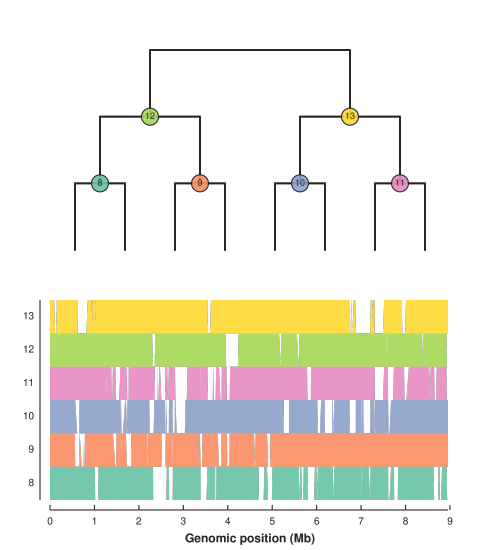

In [33]:
canvas, axes = tree_clades_slider_plot(simb5)
toyplot.html.render(canvas, "../figures/balanced_5.html")
toyplot.pdf.render(canvas, "../figures/balanced_5.pdf")
canvas

### How large are contiguous clade supporting fragments?

Hmmm, there doesn't seem to be a relationship between the depth of a split and the size of fragments (mean or std) that support the split... I thought there would have been...

In [34]:
def get_clade_lengths(self, cidx):
    lengths = []
    flen = 0
    for idx in self.clade_table.index:
        # extend fragment
        if self.clade_table.loc[idx, cidx] == 1:
            flen += 1
        # terminate fragment
        else:
            if flen:
                lengths.append(flen)
                flen = 0
    return np.array(lengths)

In [35]:
dset = simi5
for node in dset.tree.treenode.traverse():
    if not node.is_leaf() and not node.is_root():
        flens = get_clade_lengths(dset, node.idx)
        print("{}\t{:.2f}\t{:.2f}".format(node.idx, flens.mean(), flens.std()))

13	6.93	6.71
12	24.40	25.96
11	17.71	21.54
10	19.30	22.20
9	18.79	21.96
8	13.96	17.08


In [36]:
dset = simi10
for node in dset.tree.treenode.traverse():
    if not node.is_leaf() and not node.is_root():
        flens = get_clade_lengths(dset, node.idx)
        print("{}\t{:.2f}\t{:.2f}".format(node.idx, flens.mean(), flens.std()))

13	22.44	23.38
12	23.54	31.17
11	38.62	47.59
10	26.00	38.09
9	36.67	47.03
8	50.73	59.58
